In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.ticker import NullFormatter
%matplotlib inline
# import seaborn as sns
# sns.set(style="ticks")

import numpy as np

# Helpers

In [2]:
def latexify(figsize_inches=None, font_size=12):
    """Set up matplotlib's RC params for LaTeX plotting.

    This function only needs to be called once per Python session.

    Arguments
    ---------
    figsize_inches: tuple float (optional)
        width, height of figure on inches

    font_size: int
        Size of font.
    """

    usetex = matplotlib.checkdep_usetex(True)
    if not usetex:
        raise RuntimeError(
            "Matplotlib could not find a LaTeX installation on your machine."
        )

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples
    fig_width, fig_height = (
        figsize_inches if figsize_inches is not None else (None, None)
    )
    if fig_width is None:
        fig_width = 3.39

    if fig_height is None:
        golden_mean = (np.sqrt(5) - 1.0) / 2.0  # aesthetic ratio
        fig_height = fig_width * golden_mean  # height in inches

    max_height_inches = 8.0
    if fig_height > max_height_inches:
        print(
            "warning: fig_height too large:"
            + fig_height
            + "so will reduce to"
            + max_height_inches
            + "inches."
        )
        fig_height = max_height_inches

    params = {
        "backend": "ps",
        "text.latex.preamble": "\\usepackage{gensymb}",
        "axes.labelsize": font_size,
        "axes.titlesize": font_size,
        "font.size": font_size,
        "legend.fontsize": font_size,
        "xtick.labelsize": font_size,
        "ytick.labelsize": font_size,
        "text.usetex": True,
        "figure.figsize": [fig_width, fig_height],
        "font.family": "serif",
    }

    matplotlib.rcParams.update(params)

In [3]:
def _format_axes(ax, spine_color="black", linewidth=0.7):

    for spine in ["left", "bottom", "top", "right"]:
        ax.spines[spine].set_color(spine_color)
        ax.spines[spine].set_linewidth(linewidth)

    # ax.xaxis.set_ticks_position('bottom')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction="out", color=spine_color)

    return ax

# Load Data

In [4]:
import pickle

In [34]:
# dataset = "kelly_large"
# file = open("data_ECOS_noparam/ECOS_data_kelly_4_23_2021_17_16.pkl", 'rb')

dataset = "kelly"
file = open("data_ECOS_noparam/ECOS_data_kelly_4_23_2021_21_15.pkl", 'rb')

# dataset = "cvar"
# file = open("data_ECOS_noparam/ECOS_data_cvar_new_4_23_2021_21_54.pkl", 'rb')

# dataset = "exp"
# file = open("data_ECOS_noparam/ECOS_data_exp_4_23_2021_22_2.pkl", 'rb')

# dataset = "vecnewsven"
# file = open("data_ECOS_noparam/ECOS_data_vecnewsven_4_23_2021_22_18.pkl", 'rb')

stuff = pickle.load(file, encoding='latin1')
file.close()

In [35]:
objfs = stuff["objfs"]
objfs_validation = stuff["objfs_validation"]
lower_bounds = stuff["lower_bounds"]
runtimes = stuff["runtimes"]
rms_residuals = stuff["rms_residuals"]
time_cost_details = stuff["time_cost_details"]
best_xs = stuff["best_xs"]
ts = stuff["ts"]
q_norms = stuff["q_norms"]
f_grad_norms = stuff["f_grad_norms"]
num_f_evals = stuff["num_f_evals"]
iters_takens = stuff["iters_takens"]
alg_props = stuff["alg_props"]

In [36]:
print(best_xs.shape)

(200, 1)


In [37]:
num_algs, max_num_rounds = objfs.shape
n, _ = best_xs.shape
rounds = range(0, max_num_rounds)
objf_min = np.min(objfs[0, :])
print(objf_min)

-0.05716755613684654


# running min

In [38]:
start_idx = 0
objfs_running_min = np.array(objfs)
for alg_idx in range(num_algs):
    tmp_min = objfs[alg_idx, start_idx]
    for i in range(start_idx + 1, max_num_rounds):
        tmp_min = min(objfs[alg_idx, i], tmp_min)
        objfs_running_min[alg_idx, i] = tmp_min

In [39]:
start_idx = 1
rms_res_running_min = np.array(rms_residuals)
for alg_idx in range(num_algs):
    tmp_min = rms_residuals[alg_idx, start_idx]
    for i in range(start_idx + 1, max_num_rounds):
        tmp_min = min(rms_residuals[alg_idx, i], tmp_min)
        rms_res_running_min[alg_idx, i] = tmp_min

# stopping criteria

In [40]:
eps_gap_rel = 1e-3
eps_res_abs = 1e-4
eps_res_rel = 1e-3

In [41]:
for alg_idx in range(num_algs):
    stop_iters = [max_num_rounds] * 2
    for i in range(10, max_num_rounds):
        if objfs[alg_idx, i] < np.inf and objfs_validation[alg_idx, i] < np.inf and \
        objfs[alg_idx, i] - lower_bounds[alg_idx, i] <= np.abs(objfs[alg_idx, i] - objfs_validation[alg_idx, i]) \
        + eps_gap_rel * np.abs(objfs[alg_idx, i]):
            stop_iters[0] = min(i, stop_iters[0])
        if ts[alg_idx, i] == 1 and \
        rms_residuals[alg_idx, i] <= eps_res_abs \
        + eps_res_rel * (q_norms[alg_idx, i] + f_grad_norms[alg_idx, i]) / np.sqrt(n):
            stop_iters[1] = min(i, stop_iters[1])
        if max(stop_iters) < max_num_rounds:
            break
    print("iteration at which a stopping condition holds", stop_iters)
    stop_iter = min(stop_iters)

iteration at which a stopping condition holds [100, 14]


In [13]:
ep = 1e-6
for alg_idx in range(len(alg_props)):
    subopt = objfs[alg_idx, :] - np.min(objfs[alg_idx, :])
    iter_reach_ep = max_num_rounds
    for i in range(max_num_rounds):
        if subopt[i] <= ep:
            iter_reach_ep = i
            break
    f_evals = np.mean(num_f_evals[alg_idx, 1:iter_reach_ep + 1], axis=0)
    print(alg_props[alg_idx])
    print("solve time to reach 1e-6 subopt =", np.sum(runtimes[alg_idx, 0:iter_reach_ep + 1]),
          "iters =", iter_reach_ep,
          " num f evals =", f_evals)

r=0, M=1
solve time to reach 1e-6 subopt = 5.111282825469971 iters = 60  num f evals = 5.6
r=0, M=20
solve time to reach 1e-6 subopt = 8.587738990783691 iters = 52  num f evals = 4.923076923076923
r=0, M=50
solve time to reach 1e-6 subopt = 16.260106086730957 iters = 44  num f evals = 4.818181818181818
r=20, M=1
solve time to reach 1e-6 subopt = 0.8102989196777344 iters = 11  num f evals = 1.9090909090909092
r=20, M=20
solve time to reach 1e-6 subopt = 1.7253401279449463 iters = 11  num f evals = 1.9090909090909092
r=20, M=50
solve time to reach 1e-6 subopt = 3.8119289875030518 iters = 11  num f evals = 1.9090909090909092
r=50, M=1
solve time to reach 1e-6 subopt = 0.8465611934661865 iters = 11  num f evals = 1.9090909090909092
r=50, M=20
solve time to reach 1e-6 subopt = 1.7381165027618408 iters = 11  num f evals = 1.9090909090909092
r=50, M=50
solve time to reach 1e-6 subopt = 3.8561017513275146 iters = 11  num f evals = 1.9090909090909092


In [14]:
print("time cost detail")
print("===============f======grad f====subp====L_k====")
for alg_idx in range(len(alg_props)):
    f_eval = np.mean(time_cost_details[0, alg_idx, 1::])
    f_grad_eval = np.mean(time_cost_details[1, alg_idx, 1::])
    subp_ave = np.mean(time_cost_details[2, alg_idx, 1::])
    subp_first = time_cost_details[2, alg_idx, 1]
    L_k_ave = np.mean(time_cost_details[3, alg_idx, 10:100:10])
    L_k_first = time_cost_details[3, alg_idx, 10]
    print_results = [f_eval, f_grad_eval, subp_ave, L_k_ave]
    print(alg_props[alg_idx], ['{:g}'.format(float('{:.2g}'.format(print_results[i]))) for i in range(4)])

time cost detail
===============f======grad f====subp====L_k====
r=0, M=1 ['0.006', '0.011', '0.029', '0.012']
r=0, M=20 ['0.0062', '0.011', '0.062', '0.077']
r=0, M=50 ['0.0059', '0.011', '0.14', '0.39']
r=20, M=1 ['0.006', '0.011', '0.058', '0.013']
r=20, M=20 ['0.006', '0.011', '0.11', '0.07']
r=20, M=50 ['0.0058', '0.011', '0.2', '0.34']
r=50, M=1 ['0.006', '0.011', '0.061', '0.014']
r=50, M=20 ['0.0058', '0.011', '0.11', '0.093']
r=50, M=50 ['0.0059', '0.011', '0.22', '0.4']


In [33]:
print(time_cost_details[2, alg_idx, 1])
print(time_cost_details[3, alg_idx, 10])
print(time_cost_details[2, alg_idx, 10:100:10])

0.14476799964904785
0.20641541481018066
[0.14859271 0.22195649 0.18946862 0.24209094 0.21575141 0.24368739
 0.23429918 0.25067782 0.23991513]


# setting

In [16]:
linewidth = 1.0
if dataset == "kelly_large":
    figsize = (2.1 * 1.5, 2.1)
    font_size = 10
else:
    figsize = (3 * 1.5, 3)
    font_size = 11

In [17]:
latexify(figsize, font_size)

In [18]:
print(alg_props)

['r=0, M=1', 'r=0, M=20', 'r=0, M=50', 'r=20, M=1', 'r=20, M=20', 'r=20, M=50', 'r=50, M=1', 'r=50, M=20', 'r=50, M=50']


# Make plots

## Varying $r$, $M$ plots

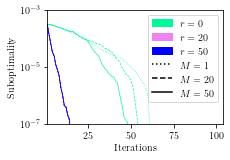

In [28]:
if dataset == "kelly_large":

    from matplotlib.patches import Patch
    import matplotlib.lines as mlines

    f,ax = plt.subplots()

    legend_elements = [Patch(facecolor="mediumspringgreen", edgecolor="mediumspringgreen", label="$r=0$"),
                       Patch(facecolor="violet", edgecolor="violet", label="$r=20$"),
                       Patch(facecolor="blue", edgecolor="blue", label="$r=50$"),   
                       mlines.Line2D([], [], linestyle=':', color='k', label="$M=1$"),
                       mlines.Line2D([], [], linestyle='--', color='k', label="$M=20$"),
                       mlines.Line2D([], [], color='k', label="$M=50$")]

    colors = ["mediumspringgreen"] * 3 + ["violet"] * 3 + ["blue"] * 3
    linestyles = ["dotted", "dashed", "solid"] * 3

    # colors = ["blue", "violet", "cyan", "green", "lime", "gold", "orangered", "sandybrown", "darkgray"]
    # linestyles = ["solid"] * 9
    # legends = ["$r=50,M=50$", "$r=50,M=20$", "$r=50,M=1$", "$r=20,M=50$", "$r=20,M=20$", "$r=20,M=1$",
    #           "$r=0,M=50$", "$r=0,M=20$", "$r=0,M=1$"]

    for alg_idx in range(num_algs):
        ax.semilogy(rounds, objfs_running_min[alg_idx, :] - np.min(objfs[alg_idx, :]), 
                    linewidth=0.7*linewidth, color=colors[alg_idx], linestyle=linestyles[alg_idx])#, label=legends[alg_idx])

    # ax.semilogy(x, baseline3, linewidth=linewidth, color="green", linestyle="dashed", label="$M=50$")
    # ax.semilogy(x, baseline4, linewidth=linewidth, color="lime", linestyle="dashed", label="$M=20$")
    # ax.semilogy(x, baseline5, linewidth=linewidth, color="gold", linestyle="dashed", label="$M=1$")

    ax.set_xlim(left=1)
    ax.set_ylim([1e-7, 1e-3])
    # ax.legend(loc="upper right", ncol=2)
    ax.legend(loc="upper right", handles=legend_elements)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Suboptimality")

#     f.savefig("../../figures/large_scale_kelly_subopt_left.pdf", bbox_inches="tight")
#     f.savefig("large_scale_dense_kelly_subopt_left.pdf", bbox_inches="tight")

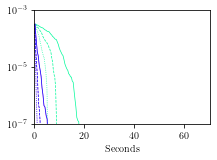

In [29]:
if dataset == "kelly_large":

    f,ax = plt.subplots()

    for alg_idx in range(num_algs):
        ax.semilogy(np.cumsum(runtimes[alg_idx, 0:max_num_rounds]), 
                    objfs_running_min[alg_idx, :] - np.min(objfs[alg_idx, :]), 
                    linewidth=0.7*linewidth, color=colors[alg_idx], linestyle=linestyles[alg_idx])

    ax.set_xlim(left=0)
    ax.set_ylim([1e-7, 1e-3])
    ax.set_xlabel("Seconds")

#     f.savefig("../../figures/large_scale_kelly_subopt_right.pdf", bbox_inches="tight")
#     f.savefig("large_scale_dense_kelly_subopt_right.pdf", bbox_inches="tight")

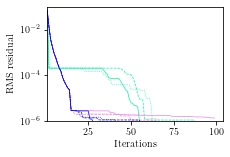

In [21]:
if dataset == "kelly_large":

    f,ax = plt.subplots()

    for alg_idx in range(num_algs):
        ax.semilogy(rounds[start_idx:max_num_rounds], 
                    rms_res_running_min[alg_idx, start_idx:max_num_rounds], 
                    linewidth=0.7*linewidth, color=colors[alg_idx], linestyle=linestyles[alg_idx])

    ax.set_xlim(left=1)
    ax.set_ylim([1e-6, 1e-1])
    ax.set_xlabel("Iterations")
    ax.set_ylabel("RMS residual")

#     f.savefig("../../figures/large_scale_kelly_rmsres_left.pdf", bbox_inches="tight")
#     f.savefig("large_scale_dense_kelly_rmsres_left.pdf", bbox_inches="tight")

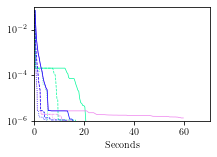

In [22]:
if dataset == "kelly_large":

    f,ax = plt.subplots()

    for alg_idx in range(num_algs):
        ax.semilogy(np.cumsum(runtimes[alg_idx, start_idx:max_num_rounds]), 
                    rms_res_running_min[alg_idx, start_idx:max_num_rounds], 
                    linewidth=0.7*linewidth, color=colors[alg_idx], linestyle=linestyles[alg_idx])

    ax.set_xlim(left=0)
    ax.set_ylim([1e-6, 1e-1])
    ax.set_xlabel("Seconds")

#     f.savefig("../../figures/large_scale_kelly_rmsres_right.pdf", bbox_inches="tight")
#     f.savefig("large_scale_dense_kelly_rmsres_right.pdf", bbox_inches="tight")

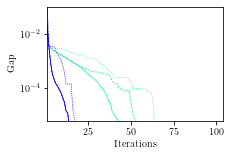

In [31]:
if dataset == "kelly_large":

    f,ax = plt.subplots()
    
    for alg_idx in range(9):
        ax.semilogy(rounds, objfs[alg_idx, :] - lower_bounds[alg_idx, :], linewidth=0.7*linewidth, 
                    color=colors[alg_idx], linestyle=linestyles[alg_idx])

    ax.set_xticks([25,50,75,100])
    ax.set_xlim(left=1)
#     ax.set_ylim([6e-6, 1e-1])
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Gap")

#     f.savefig("../../figures/large_scale_kelly_gap_left.pdf", bbox_inches="tight")
#     f.savefig("large_scale_dense_kelly_gap_left.pdf", bbox_inches="tight")

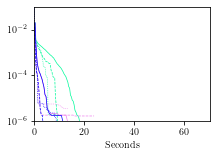

In [24]:
if dataset == "kelly_large":

    f,ax = plt.subplots()

    for alg_idx in range(num_algs):
        ax.semilogy(np.cumsum(runtimes[alg_idx, 0:max_num_rounds]), 
                    objfs[alg_idx, :] - lower_bounds[alg_idx, :], 
                    linewidth=0.7*linewidth, color=colors[alg_idx], linestyle=linestyles[alg_idx])

    ax.set_xlim(left=0)
    ax.set_ylim([1e-6, 1e-1])
    ax.set_xlabel("Seconds")

#     f.savefig("../../figures/large_scale_kelly_gap_right.pdf", bbox_inches="tight")
#     f.savefig("large_scale_dense_kelly_gap_right.pdf", bbox_inches="tight")

In [25]:
if dataset == "kelly_large":
    assert False

AssertionError: 

## Optimality gap plots

In [ ]:
xlims = {"kelly":[1,40],
         "cvar":[1,120],
         "exp":[1,50],
         "vecnewsven":[1,80]}

In [ ]:
ylims = {"kelly":([1e-7, 1e-3], None),
         "cvar":(None, None),
         "exp":(None, None),
         "vecnewsven":(None, [1e-2, 1])}

In [ ]:
f,ax = plt.subplots()

lower_bounds_fixed = [min(lower_bounds[alg_idx, i], np.min(objfs[alg_idx, :])) 
                      for i in range(max_num_rounds)]

ax.semilogy(rounds, objfs_running_min[alg_idx, :] - np.min(objfs[alg_idx, :]), 
            linewidth=linewidth, color="orangered", linestyle="solid", label="Suboptimality")

if np.max(lower_bounds[alg_idx, :]) > -np.inf:
    ax.semilogy(rounds, objfs[alg_idx, :] - lower_bounds_fixed, 
                linewidth=linewidth, color="sandybrown", linestyle="solid", label="Gap")
if np.min(objfs_validation[alg_idx, 1::]) < np.inf and \
np.min(np.abs(objfs[alg_idx, 1::] - objfs_validation[alg_idx, 1::])) > 0:
    ax.semilogy(rounds[1::], np.abs(objfs[alg_idx, 1::] - objfs_validation[alg_idx, 1::]),
                linewidth=linewidth, color="darkgray", linestyle="solid", label="Sampling accuracy")

ax.set_xlim(xlims[dataset])
if ylims[dataset][0] is not None:
    ax.set_ylim(ylims[dataset][0])
ax.legend(loc="upper right")
ax.set_xlabel("Iterations")
ax.axvline(stop_iter, color="black", linestyle="dotted", linewidth=linewidth) # Us ("practical")
ax.axvline(iter_reach_ep, color="lime", linestyle="dotted", linewidth=linewidth) # 1e-6 ("high")

# f.savefig("../../figures/" + dataset + "_cvg_top.pdf", bbox_inches="tight")
# f.savefig(dataset + "_cvg_top.pdf", bbox_inches="tight")

## Residual plots

In [ ]:
f,ax = plt.subplots()
ax.semilogy(rounds[start_idx::], rms_res_running_min[alg_idx, start_idx::], 
            linewidth=linewidth, color="orangered", linestyle="solid", label="RMS residual")
ax.set_xlim(xlims[dataset])
if ylims[dataset][1] is not None:
    ax.set_ylim(ylims[dataset][1])
ax.legend(loc="upper right")
ax.set_xlabel("Iterations")
ax.axvline(stop_iter, color="black", linestyle="dotted", linewidth=linewidth)
ax.axvline(iter_reach_ep, color="lime", linestyle="dotted", linewidth=linewidth)

# f.savefig("../../figures/" + dataset + "_cvg_bottom.pdf", bbox_inches="tight")
# f.savefig(dataset + "_cvg_bottom.pdf", bbox_inches="tight")

In [ ]:
assert False

# Notes

Play with the figsize variable (above) so that you don't have to use width/height/scale/whatever in the LaTeX to get the image size to look "right"; i.e., the plot should be the right size "as-is".

For multiple side-by-side plots (e.g., Fig 1), keep only putting the legend in the top left-most plot (as you are currently doing).

I would probably just put one vertical line to indicate when OSMM terminates (as above). I.e., I probably wouldn't put multiple "stars" (or whatever they are) on the lines (e.g., as in the right panel of Fig 9).